In order to get ground truth, we're going to download data from OpenStreetMaps.  OpenStreetMaps can be hard to work with, but fortunately there is a great library that can help called geopandas osm.  If you haven't already, you will need to set up the geospatial tools before you can use this script.

This script downloads map features from OSM.  OSM has a lot of different features, like buildings, waterways, and nature.  You can find a description of the features on the [OSM Wiki](http://wiki.openstreetmap.org/wiki/Map_Features)

In [1]:
import json

import shapely.geometry
import geopandas as gpd
import geopandas_osm.osm

meta_df = gpd.read_file('vectors/image_metadata.geojson')
poly = shapely.geometry.box(*meta_df.unary_union.bounds)

osm_df = geopandas_osm.osm.query_osm('way', poly, recurse='down', tags='building')
building_columns = osm_df.columns

buildings = osm_df[~osm_df.building.isnull()][['building', 'name', 'geometry']]
building_centroids = buildings.set_geometry(buildings.centroid, inplace=False)
building_centroids.to_file('vectors/building_centers.geojson', 'GeoJSON')

/home/alan/.virtualenvs/drago/lib/python3.5/site-packages/geopandas_osm/osm.py:299: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]


Now that we downloaded the buildings, let's have a look at all the different building types, and how often they occur.

In [3]:
from collections import Counter

Counter(building_centroids.building.values)

Counter({'abandoned': 1,
         'amenity': 1,
         'apartments': 18,
         'church': 15,
         'civic': 5,
         'commercial': 2,
         'construction': 3,
         'farm': 1,
         'garage': 133,
         'garages': 10,
         'greenhouse': 1,
         'historic': 1,
         'hospital': 1,
         'house': 54,
         'industrial': 1,
         'kindergarten': 1,
         'office': 5,
         'public': 1,
         'residential': 1010,
         'retail': 49,
         'roof': 38,
         'school': 41,
         'shop': 1,
         'temple': 1,
         'train_station': 13,
         'walled': 1,
         'warehouse': 1,
         'yes': 68644})

We can see that these match up with the building types described on the [OSM Wiki](http://wiki.openstreetmap.org/wiki/Map_Features#Building).  If you want to view the geojson file you downloaded, you can use QGIS or [geojson.io](http://geojson.io)

Next, let's get the land-use data that's in OSM.

In [4]:
osm_df = geopandas_osm.osm.query_osm('way', poly, recurse='down', tags='landuse')
landuse = osm_df[~osm_df.landuse.isnull()]
print(landuse.landuse.unique())
print(landuse.shape)
landuse.to_file('vectors/landuse.geojson', 'GeoJSON')

/home/alan/.virtualenvs/drago/lib/python3.5/site-packages/geopandas_osm/osm.py:299: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]


['cemetery' 'grass' 'forest' 'basin' 'retail' 'recreation_ground'
 'industrial' 'farmyard' 'quarry' 'school' 'residential' 'vineyard'
 'allotments' 'commercial' 'farmland' 'construction' 'sand' 'brownfield'
 'greenhouse_horticulture' 'subdivision' 'meadow']
(332, 50)


Now let's download the waterways

In [5]:
osm_df = geopandas_osm.osm.query_osm('way', poly, recurse='down', tags='waterway')
waterways = osm_df[~osm_df.waterway.isnull()]
print(waterways.waterway.unique())
print(waterways.shape)
waterways.to_file('vectors/waterways.geojson', 'GeoJSON')

['stream' 'riverbank' 'river']
(41, 6)


/home/alan/.virtualenvs/drago/lib/python3.5/site-packages/geopandas_osm/osm.py:299: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]


Finally, let's get the natural features that are marked in OSM.

In [6]:
osm_df = geopandas_osm.osm.query_osm('way', poly, recurse='down', tags='natural')
nature = osm_df[~osm_df.natural.isnull()]
print(nature.natural.unique())
print(nature.shape)
nature.to_file('vectors/nature.geojson', 'GeoJSON')

['fell' 'water' 'wood' 'sand']
(58, 8)


/home/alan/.virtualenvs/drago/lib/python3.5/site-packages/geopandas_osm/osm.py:299: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]


We're going to need to decide what categories to train our model on.  In order to decide that, let's look at the GlobCover categories, and the land types in OSM and decide how to categorize things.

Here are the land types in GlobCover
* Post-flooding or irrigated croplands (or aquatic)
* Rainfed croplands
* Mosaic cropland (50-70%) / vegetation (grassland/shrubland/forest) (20-50%)
* Mosaic vegetation (grassland/shrubland/forest) (50-70%) / cropland (20-50%) 
* Closed to open (>15%) broadleaved evergreen or semi-deciduous forest (>5m)
* Closed (>40%) broadleaved deciduous forest (>5m)
* Open (15-40%) broadleaved deciduous forest/woodland (>5m)
* Closed (>40%) needleleaved evergreen forest (>5m)
* Open (15-40%) needleleaved deciduous or evergreen forest (>5m)
* Closed to open (>15%) mixed broadleaved and needleleaved forest (>5m)
* Mosaic forest or shrubland (50-70%) / grassland (20-50%)
* Mosaic grassland (50-70%) / forest or shrubland (20-50%) 
* Closed to open (>15%) (broadleaved or needleleaved, evergreen or deciduous) shrubland (<5m)
* Closed to open (>15%) herbaceous vegetation (grassland, savannas or lichens/mosses)
Sparse (<15%) vegetation
* Closed to open (>15%) broadleaved forest regularly flooded (semi-permanently or temporarily) - Fresh or brackish water
* Closed (>40%) broadleaved forest or shrubland permanently flooded - Saline or brackish water
* Closed to open (>15%) grassland or woody vegetation on regularly flooded or waterlogged soil - Fresh, brackish or saline water
* Artificial surfaces and associated areas (Urban areas >50%)
* Bare areas
* Water bodies
* Permanent snow and ice
* No data (burnt areas, clouds,…)

Looking at the data from OSM, I think reasonable categories would be:
* Water
* Wood
* Urban

We can get find the land in each category by looking at the OSM features.

# Matching OSM data to the SpaceNet images
Let's try something a little more advanced and find objects that fall inside the images.




In [38]:
import os

import rasterio

image_dir_path = '/mnt/OSN_Data/spacenet/AOI_2_Vegas_Train/MUL-PanSharpen'

tiff_images = [os.path.join(image_dir_path, image_name) 
               for image_name in os.listdir(image_dir_path) 
               if image_name.lower().endswith('tif')]

res = []
for image_file_name in tiff_images:
    with rasterio.open(image_file_name) as src:
        bbox = shapely.geometry.box(*src.bounds)
    res.append((image_file_name, bbox))
image_summary = gpd.GeoDataFrame(res, columns=['image_name', 'geometry'], crs={'init': 'epsg:4326'})
poly = shapely.geometry.box(*image_summary.unary_union.bounds)

In [39]:
# tag = 'generator:source=solar'
osm_df = geopandas_osm.osm.query_osm('way', poly, recurse='down', tags='power')
osm_df.columns

/home/alan/.virtualenvs/drago/lib/python3.5/site-packages/geopandas_osm/osm.py:299: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]


Index(['barrier', 'building', 'cables', 'frequency', 'generator:method',
       'generator:output:electricity', 'generator:source', 'generator:type',
       'geometry', 'id', 'landuse', 'location', 'power', 'type', 'voltage'],
      dtype='object')

In [40]:
osm_df['generator:type'].unique()

array([nan, 'solar_photovoltaic_panel'], dtype=object)

In [41]:
(osm_df['generator:type'] == 'solar_photovoltaic_panel').sum()

1

In [42]:
osm_df['generator:source'].unique()

array([nan, 'solar'], dtype=object)

In [44]:
(osm_df['generator:source'] == 'solar').sum()

3

In [45]:
osm_df['generator:method'].unique()

array([nan, 'photovoltaic'], dtype=object)

In [46]:
(osm_df['generator:method'] == 'photovoltaic').sum()

2

OSM metadata is not consistent.  It looks like there are 6 total solar panels marked, and they're marked in different ways.  Lets check if any of them are inside our images.

In [95]:
is_solar = (osm_df['generator:type'] == 'solar_photovoltaic_panel') | (osm_df['generator:source'] == 'solar') | (osm_df['generator:method'] == 'photovoltaic')
solar_panels = osm_df[is_solar]
solar_images = image_summary[image_summary.intersects(solar_panels.unary_union)]
len(solar_images)

5

It looks like 5 of them interset our images! Let's look at one.  

Apologies, but things are about to get really complicated.  Ill explain them some other time.

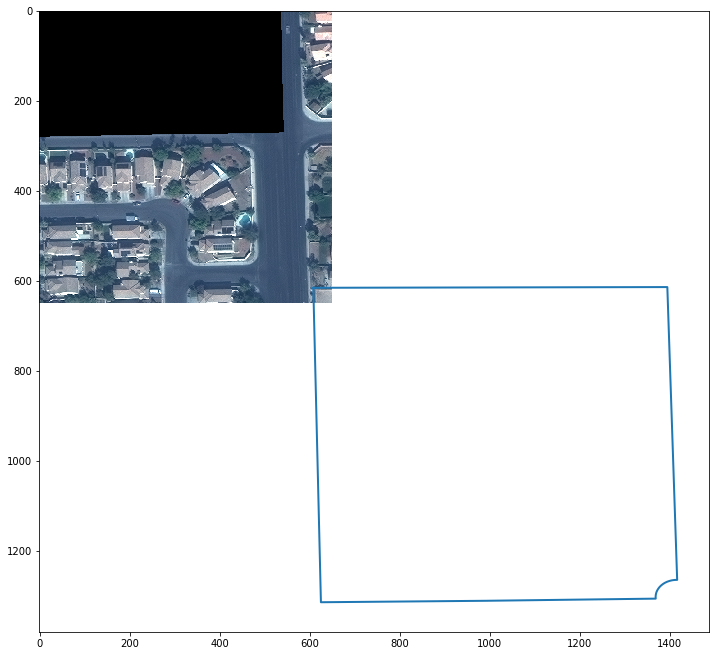

In [132]:
import numpy as np

with rasterio.open(solar_images.iloc[0].image_name) as src:
        img = src.read([5, 3, 2]).transpose([1,2,0])
        img_bounds = shapely.geometry.box(*src.bounds)
        img_transform = list(np.array(~src.affine)[[0, 1, 3, 4, 2, 5]])


panel_geometry = solar_panels[solar_panels.intersects(img_bounds)].unary_union
panel_geometry_imcoords = shapely.affinity.affine_transform(panel_geometry, img_transform)

def scale_bands(img, lower_pct = 1, upper_pct = 99):
    """
    Rescale the bands of a multichannel image
    """
    # Loop through the image bands, rescaling each one
    img_scaled = np.zeros(img.shape, np.uint8)
    for i in range(img.shape[2]):
        band = img[:, :, i]
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        band = (band - lower) / (upper - lower) * 255
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
    return img_scaled

import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(scale_bands(img))


ax.plot(*panel_geometry_imcoords.xy, linewidth=2)


Well that's not what I was expecting.  It looks like we're not going to be ale to work with these markings.  On the other hand, I'm pretty sure I see some solar panels in that image.